In [ ]:
New pumpistor - for our purposes

In [1]:
from matplotlib import pyplot as plt
from numpy import linspace
import numpy as np
import scipy
import scipy.optimize
import scipy.integrate
from pylab import *

pi = 3.14159
fi_0 = 2.07e-15/2/3.141592

I_c = 5e-6
C = 2e-12
N = 1.

print 'w0 =',(C*N*(fi_0 / I_c))**-0.5/6.28e9, 'GHz'

w0 = 13.871233322 GHz


In [17]:
def G_0(x,F,f): #x = w_p*t
    return( np.abs(np.cos(F + f*np.cos(x))) /2/pi )

def G_1(x,F,f): #x = w_p*t
    return( np.abs(np.cos(F + f*np.cos(x))) * np.cos(x)/pi )

def G_2(x,F,f): #x = w_p*t
    return( np.abs(np.cos(F + f*np.cos(x))) * np.cos(2*x)/pi )
        
def a_0(F,f):
    return(scipy.integrate.quad(lambda x: G_0(x,F,f) ,-pi,pi)[0])

def a_1(F,f):
    return(scipy.integrate.quad(lambda x: G_1(x,F,f) , -pi,pi)[0])

def a_2(F,f):
    return(scipy.integrate.quad(lambda x: G_2(x,F,f) , -pi,pi)[0])


def epsilon_0(F,f,a_0,a_1):
    return (a_0/np.cos(F))
#    return(1.- 0.25*f**2)
    
def epsilon_1(F,f,a_0,a_1):
    return( 0.5*a_1/np.cos(F) )
#    return(0.5*f*np.tan(F))
           
def L_J(F,f,a_0,a_1):
    return(N*fi_0/(I_c*np.cos(F)))

In [18]:
def V2divV1(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh):  #All admittances are expected at idler freq
    x = -1j*epsilon_1(F,f,a_0,a_1)*(1. + Yr/Ym).conjugate()/w_s/L_J(F,f,a_0,a_1)
    x = x/(-1j*epsilon_0(F,f,a_0,a_1)*(1. + Yr/Ym).conjugate()/(w_p - w_s)/L_J(F,f,a_0,a_1) - (Ysh + Yr + Ysh*Yr/Ym).conjugate())
    return(x)


def V2divV1_smallY(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh):  #All admittances are expected at idler freq
    x = -1j*epsilon_1(F,f,a_0,a_1)*(Ym + Yr).conjugate()/w_s/L_J(F,f,a_0,a_1)
    x = x/(-1j*epsilon_0(F,f,a_0,a_1)*(Ym + Yr).conjugate()/(w_p - w_s)/L_J(F,f,a_0,a_1) - (Ysh*Ym + Yr*Ym + Ysh*Yr).conjugate())
    return(x)


def Y_JPA(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh):
    return( -1j* ( epsilon_0(F,f,a_0,a_1)/w_s - epsilon_1(F,f,a_0,a_1)*V2divV1(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh)/(w_p - w_s) ) / L_J(F,f,a_0,a_1) )

def Y_JPA_smallY(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh):
    return( -1j* ( epsilon_0(F,f,a_0,a_1)/w_s - epsilon_1(F,f,a_0,a_1)*V2divV1_smallY(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh)/(w_p - w_s) ) / L_J(F,f,a_0,a_1) )


def Y_sh(w):
    return(1j*w*C)

def Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh):
    return(Y_JPA(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh) + Y_sh(w_s))

def Y_SQ_smallY(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh):
    return(Y_JPA_smallY(F,f,a_0,a_1, w_p, w_s, Yr, Ym, Ysh) + Y_sh(w_s))

In [19]:

def Gain(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2): #1-signal, 2 - idler
    g = (1./Yr1 - 1./Ym1 - 1./Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))/(1./Yr1 + 1./Ym1 + 1./Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))
    #g = (Yr1  - Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))/(Yr1  + Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))
    return(20*np.log10(np.abs(g)))
    #return g
    
    
def Gain_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2): #1-signal, 2 - idler
    g = (Ym1/Yr1 - 1. - Ym1/Y_SQ_smallY(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))/(Ym1/Yr1 + 1. + Ym1/Y_SQ_smallY(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))
    #g = (Yr1  - Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))/(Yr1  + Y_SQ(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2))

    return(20*np.log10(np.abs(g)))
    #return g

In [26]:
####Test
F = 0.0012*pi
f = 0.002*pi
w_p = 14 * 6.28e9

print (L_J(F,f,a_0(f,F),a_1(f,F))*C)**-0.5/6.28e9

a0 = a_0(F,f)
a1 = a_1(F,f)

Yreal = 1./50.

w = linspace(4*6.28e9,10*6.28e9,5e4)

#w = w_p + 100e6
#fArr = linspace(0.01*pi,0.5*pi,1e3)
#g = []
#for x in linspace(0.01*pi,0.4*pi,1e3):
#    g.append(Gain(F,x,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) ))

plt.plot(w/6.28e9, Gain(F,f,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) ))
#plt.plot(fArr, g)
plt.xlabel('w_s, Ghz')
plt.ylabel('G_s')
plt.title('')
plt.show()

12.8822904185


In [17]:
w_p = 13 * 6.28e9
Number = 30
step = 0.5*pi/Number

Farr = linspace(0., 0.5*pi, Number)
farr = linspace(0., 0.5*pi, Number)
Garr = []

for i in range(Number):
    Garr.append([])
    for k in range(Number):
        a0 = a_0(step*i,step*k)
        a1 = a_1(step*i,step*k)
        Garr[i].append(np.max(Gain(F,f,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) )))

contourf(  Farr/pi,farr/pi, Garr, 100, alpha=0.75, cmap='copper')
colorbar()
xlabel("f/pi")
ylabel("F/pi")
show()

In [28]:
#Optimization
#Yreal must be fond somewhere else
F = 0.12*pi
f = 0.2*pi
w_p = 14 * 6.28e9

a0 = a_0(F,f)
a1 = a_1(F,f)

Yreal = 1./50


length_w = 100
length_Y = 101
wStart = w_p/2
wStop = 6.28e9*7.5
YStart = 0.1
YStop = -0.5


w = linspace(wStart, wStop,length_w)

def Y_quan(i):
    return(1j*(YStart + i*(YStop - YStart)/length_Y) )

def w_quan(n):
    return(wStart + n*(wStop - wStart)/length_w)

#
G_buf = []
G_idler = []
G = []
YmSi = []
YmId = []

Gbuf1 = 0 
Gbuf2 = 0
YsBuf = 0 + 0j
YiBuf = 0 + 0j

for k in range(length_w):
    #G_buf = []
    for l in range(length_Y):#Ym1
        for m in range(length_Y):#Ym2
                    Gbuf2 = Gain(F,f,a0,a1, w_p, w_quan(k), Yreal, Y_quan(l), Y_sh(w_quan(k)) ,Yreal , Y_quan(m), Y_sh(w_p - w_quan(k)) )
                    if (np.abs(Gbuf2-20.) < np.abs(Gbuf1-20.)):
                        if (k==0)&( Y_quan(l)!= Y_quan(m)):
                            continue
                        Gbuf1 = Gbuf2
                        YsBuf = Y_quan(l)
                        YiBuf = Y_quan(m)
                        #test
                        
                        
    G_buf.append(Gbuf1)
    G_idler.append(Gain(F,f,a0,a1, w_p, w_quan(k), Yreal, YiBuf, Y_sh(w_p - w_quan(k)) ,Yreal , YsBuf, Y_sh(w_quan(k))))
    YmSi.append(YsBuf.imag)
    YmId.append(YiBuf.imag)
    
    Gbuf1 = 0
    Gbuf2 = 0
    YsBuf = 0 + 0j
    YiBuf = 0 + 0j
    
plt.plot(w/6.28e9, G_buf)
plt.plot((w_p - w)/6.28e9, G_idler)
plt.show()


In [46]:
plt.plot(w/6.28e9, YmSi)
plt.plot((w_p - w)/6.28e9, YmId)
plt.show()

In [47]:
plt.plot(w/6.28e9, G_buf)
plt.plot((w_p - w)/6.28e9, G_idler)
plt.show()

In [6]:
F = 0.12*pi
f = 0.2*pi
w_p = 14 * 6.28e9

a0 = a_0(F,f)
a1 = a_1(F,f)

Yreal = 1./50


length_w = 100
length_Y = 101
wStart = w_p/2
wStop = 6.28e9*7.3
YStart = 0.1
YStop = -0.5


w = linspace(wStart, wStop,length_w)

def Y_quan(i):
    return(1j*(YStart + i*(YStop - YStart)/length_Y) )

def w_quan(n):
    return(wStart + n*(wStop - wStart)/length_w)

#
G_buf = []
G_idler = []
G = []
YmSi = []
YmId = []

Gbuf1 = 0 
Gbuf2 = 0
YsBuf = 0 + 0j
YiBuf = 0 + 0j
YsSmoother = 0j
YiSmoother = 0j
YsOld = 0j
YiOld = 0j

def IfSmooth(YsSmoother,YiSmoother, Ys,Yi,YsOld, YiOld):
    if ((np.abs(Ys - YsSmoother)<=np.abs(YsOld - YsSmoother))&(np.abs(Yi - YiSmoother)<=np.abs(YiOld - YiSmoother))):
        return True
    else:
        return False

for k in range(length_w):
    #G_buf = []
    for l in range(length_Y):#YmSi
        for m in range(length_Y):#YmId
                    if (k==0)&( Y_quan(l)!= Y_quan(m)):
                            continue
                            
                    Gbuf2 = Gain_smallY(F,f,a0,a1, w_p, w_quan(k), Yreal, Y_quan(l), Y_sh(w_quan(k)) ,Yreal , Y_quan(m), Y_sh(w_p - w_quan(k)) )
                    
                    if (k==0):
                        if ( np.abs(Gbuf2-20.) <  np.abs(Gbuf1-20.)):
                            Gbuf1 = Gbuf2
                            YsBuf = Y_quan(l)
                            YiBuf = Y_quan(m)
                            continue
                            
                    else:        
                        if (( np.abs(Gbuf2-20.) < 1.)& IfSmooth(YsSmoother,YiSmoother,Y_quan(l), Y_quan(m),YsBuf,YiBuf)):
    
                            Gbuf1 = Gbuf2
                            YsBuf = Y_quan(l)
                            YiBuf = Y_quan(m)
                            #test
    YsSmoother = YsBuf
    YiSmoother = YiBuf                
                        
    G_buf.append(Gain_smallY(F,f,a0,a1, w_p, w_quan(k), Yreal, YsBuf, Y_sh(w_quan(k)) ,Yreal , YiBuf, Y_sh(w_p - w_quan(k)) ))
    G_idler.append(Gain_smallY(F,f,a0,a1, w_p, w_p - w_quan(k), Yreal, YiBuf, Y_sh(w_p - w_quan(k)) ,Yreal , YsBuf, Y_sh(w_quan(k))))
    YmSi.append(YsBuf.imag)#!!!!
    YmId.append(YiBuf.imag)#!!!!!
    
    Gbuf2 = 0
    YsBuf = 1e99
    YiBuf = 1e99
    
plt.plot(w/6.28e9, G_buf)
plt.plot((w_p - w)/6.28e9, G_idler)
plt.show()

In [13]:
w = linspace(wStart, wStop,length_w)
#Zid = []
#Zsi = []
#for k in range(len(YmSi)):
#    Zsi.append(1./YmSi[k])
#    Zid.append(1./YmId[k])
    
plt.plot(w/6.28e9, YmSi)
plt.plot((w_p - w)/6.28e9, YmId)

#plt.plot(w/6.28e9, Zsi)
#plt.plot((w_p - w)/6.28e9, Zid)

plt.show()

KeyboardInterrupt: 

In [115]:
plt.plot(w/6.28e9, Gain(F,f,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) ))
plt.plot((w_p - w)/6.28e9, Gain(F,f,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) ))
plt.plot(w/6.28e9, G_buf)
plt.plot((w_p - w)/6.28e9, G_idler)
plt.show()

In [109]:
np.savetxt('YmSi.txt',YmSi)
np.savetxt('YmId.txt',YmId)
np.savetxt('w.txt',w)
np.savetxt('w_p.txt',w_p - w)
np.savetxt('GainSignal.txt',G_buf)
np.savetxt('GainIdler.txt',G_idler)

In [7]:
###fitting 
length_w = 100
length_Y = 101
wStart = w_p/2
wStop = 6.28e9*7.3
YStart = 0.1
YStop = -0.5


w = linspace(wStart, wStop,length_w)
def g(l1,l2, c1,c2,w): #2 - parallel
  #  z = 50.
    #return( -1./(w*l1 - 1./w/c1    )  )
    return( -1./( 1./( 1./w/l1 - w*c1 ) + 1./( 1./w/l2 - w*c2 )  )  ) #####BEST
    #return( 1./( 1./(w*l1 - 1./w/c1 ) + 1./( w*l2 - 1./w/c2 )  )  )
 

def integrate(l1,l2, c1,c2):
    wLen = len(w)
    S = 0
    delta = (wStop-wStart)/wLen
    for x in range(wLen):
        S = S + delta*np.abs(YmSi[x] - g(l1,l2, c1,c2,w_quan(k)))
        S = S + delta*np.abs(YmId[x] - g(l1,l2, c1,c2,w_p - w_quan(k)))
    return S

ToCompare = 1e100
for c1 in linspace(1e-12, 5e-12, 100):
    for l1 in linspace(5e-9, 1e-8, 50):
        for c2 in linspace(1e-14, 1e-12, 1):
            for l2 in linspace(1e-11, 1e-9, 1):
                if(integrate(l1,l2, c1,c2) <ToCompare):
                    L1 = l1
                    C1 = c1
                    L2 = l2
                    C2 = c2
                    ToCompare = integrate(l1,l2, c1,c2)

print L1,L2,C1,C2
plt.plot(w/6.28e9, g(L1,L2,C1,C2,w))
#plt.plot(w/6.28e9, -6e-12*w + 0.2532)
plt.show()

NameError: global name 'YmSi' is not defined

In [8]:
L1 = 4e-10
L2 = .85e-9
C1 = .97e-12
C2 = .9e-12

print (L1*C1)**-0.5/6.28e9
print (L2*C2)**-0.5/6.28e9

plt.plot(w/6.28e9, g(L1,L2,C1,C2,w))
a = w_p - w
plt.plot(a/6.28e9, g(L1,L2,C1,C2,a))
#plt.plot(w/6.28e9, -6e-12*w + 0.2532)
xlabel('Freq, GHz ')
ylabel('imaginary impedance, 1j * Ohms')
show()
plt.show()

8.08396628291
5.75717775527


In [37]:


def g1(l1,l2, c1,c2,w): #2 - parallel
    return( -1./(w*l1 - 1./w/c1  )  )

def g(l1,l2, c1,c2,w): #2 - parallel
  #  z = 50.
    L_parasit = 1e-10
    #return( -1./(w*l1 - 1./w/c1  )  )
   #return( -1./(w*l1 - 1./w/c1 + ( 1./w/l2 - w*c2 )  )  )
    #return( -1./( 1./( 1./w/l1 - w*c1 ) + 1./( 1./w/l2 - w*c2 )  )  ) #####BEST
    return( -1./(w*L_parasit + 1./( 1./w/l1 - w*c1 ) + 1./( 1./w/l2 - w*c2 )  )  ) #####BEST

In [45]:
#F = 0.17*pi
#f = 0.26*pi
F = 0.12*pi
f = 0.2*pi
w_p = 14 * 6.28e9

a0 = a_0(F,f)
a1 = a_1(F,f)

Yreal = 1./50.

w = linspace(6.28e9 * 7, 6.28e9*9.5,1e5)
#L1 = 4e-10
#L2 = .92e-9
#C1 = 9e-13
#C2 = 1e-12 #.9

#L1 = 10.8e-09
#C1 = 4.85e-14

L1 = 3e-10#4e
L2 = .9e-9  #d_in = 0.   d_out = 75e-6 #m   n = 5.
C1 = 9.7e-13
C2 = .9e-12

plt.plot(w/6.28e9, Gain(F,f,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) ), 'b',linewidth = 3)
plt.plot(w/6.28e9, Gain(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,C1,C2,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,C1,C2,w_p - w), Y_sh(w_p - w) ),'r',linewidth = 3)

a = w_p - w
plt.plot(a/6.28e9, Gain(F,f,a0,a1, w_p, a, Yreal, 1e99*1j, Y_sh(a) ,Yreal , 1e99*1j, Y_sh(w_p - a) ), 'b',linewidth = 3)
plt.plot(a/6.28e9, Gain(F,f,a0,a1, w_p, a, Yreal, 1j*g(L1,L2,C1,C2,a), Y_sh(a) ,Yreal , 1j*g(L1,L2,C1,C2,w_p - a), Y_sh(w_p - a) ),'r',linewidth = 3)

#plt.xlabel("Frequency, Ghz")
#plt.ylabel("Gain, dB")
plt.legend("ab")
plt.show()
print (L1*C1)**-0.5/6.28e9
print (L2*C2)**-0.5/6.28e9

9.33456021912
5.59497109018


In [46]:
a = w_p - w

def Z(g):
    return 1./g

plt.plot(w/6.28e9, g(L1,L2,C1,C2,w), 'b')
plt.plot(a/6.28e9, g(L1,L2,C1,C2,a), 'b')

plt.ylim(-0.5, 0.3)
#plt.plot(w/6.28e9, -6e-12*w + 0.2532)
plt.xlabel("Frequency, Ghz")
plt.ylabel("Admittance, 1j*Ohm^-1")
plt.show()

In [14]:
###6 elements fitting 

def g(l1,l2,l3, c1,c2,c3,w): #2 - parallel
  #  z = 50.
    return( -1./( 1./( 1./w/l1 - w*c1 ) + 1./( 1./w/l2 - w*c2 ) + + 1./( 1./w/l3 - w*c3 )  )  ) #####BEST
 

def integrate(l1,l2,l3, c1,c2,c3):
    wLen = len(w)
    S = 0
    delta = (wStop-wStart)/wLen
    for x in range(wLen):
        S = S + delta*np.abs(YmSi[x] - g(l1,l2,l3, c1,c2,c3,w_quan(k)))
        S = S + delta*np.abs(YmId[x] - g(l1,l2,l3, c1,c2,c3,w_p - w_quan(k)))
    return S

ToCompare = 1e100
length_cycle = 5

for c1 in linspace(1e-14, 1e-13, length_cycle):
    for l1 in linspace(5e-10, 5e-9, length_cycle):
        for c2 in linspace(1e-13, 1e-12, length_cycle):
            for l2 in linspace(1e-10, 1e-9, length_cycle):
                for c3 in linspace(1e-13, 5e-12, length_cycle):
                    for l3 in linspace(1e-10, 5e-9,length_cycle):
                        if(integrate(l1,l2,l3, c1,c2,c3) <ToCompare):
                            L1 = l1
                            C1 = c1
                            L2 = l2
                            C2 = c2
                            L3 = l3
                            C3 = c3
                            ToCompare = integrate(l1,l2,l3, c1,c2,c3)
    
print L1,L2,L3,C1,C2,C3
plt.plot(w/6.28e9, g(L1,L2,L3,C1,C2,C3,w))
#plt.plot(w/6.28e9, -6e-12*w + 0.2532)
plt.show()

5e-09 7.75e-10 3.775e-09 7.75e-14 7.75e-13 1e-13


In [15]:
#L1 = 5e-9
#L2 =1.4e-9
#L3 =1.1e-10 ###
#C1 = 5e-14
#C2 = .95e-12
#C3 = 4.6e-2 ###

L1 = .51e-9
L2 =1.4e-9 ###
L3 =.1e-09
C1 = 5e-14
C2 = .9e-12
C3 = 4.3e-12

plt.plot(w/6.28e9, Gain_smallY(F,f,a0,a1, w_p, w, Yreal, 1e99*1j, Y_sh(w) ,Yreal , 1e99*1j, Y_sh(w_p - w) ),'r')
plt.plot(w/6.28e9, Gain_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w) ),'b')

a = w_p - w
plt.plot(a/6.28e9, Gain_smallY(F,f,a0,a1, w_p, a, Yreal, 1e99*1j, Y_sh(a) ,Yreal , 1e99*1j, Y_sh(w_p - a) ),'r')
plt.plot(a/6.28e9, Gain_smallY(F,f,a0,a1, w_p, a, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,a), Y_sh(a) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - a), Y_sh(w_p - a) ),'b')
plt.show()

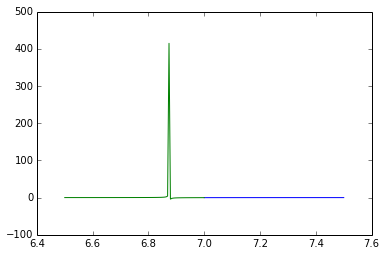

In [10]:
plt.plot(w/6.28e9, g(L1,L2,L3,C1,C2,C3,w))
plt.plot(a/6.28e9, g(L1,L2,L3,C1,C2,C3,a))
plt.show()


ValueError: x and y must have same first dimension

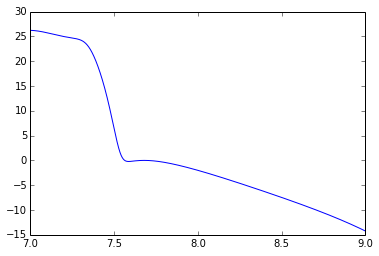

In [38]:
###just a test


t = Gain(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w) )

delta = 1/(1 + 1j*50*g(L1,L2,L3,C1,C2,C3,w))

gain = delta + (1-delta)*t

t2 = Gain(F,f,a0,a1, w_p, a, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,a), Y_sh(a) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - a), Y_sh(w_p - a) )

delta2 = 1/(1 + 1j*50*g(L1,L2,L3,C1,C2,C3,a))

gain2 = delta + (1-delta)*t

plt.plot(w/6.28e9, 20*np.log10(np.abs(gain)))
plt.plot(a/6.28e9, 20*np.log10(np.abs(gain2)))
plt.show()


Noise tryout

In [16]:
def V_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    V = I_0 / ( (Ysh1 + Yr1 + Yr1*Ysh1/Ym1) + (1. + Yr1/Ym1)*(epsilon_0(F,f,a_0,a_1)/w_s - V2divV1(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2) * epsilon_1(F,f,a_0,a_1)/w_i )/(1j*L_J(F, f, a_0, a_1)) )
    return(V)

def V_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    return( V2divV1(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2)*V_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0) )

def I_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    V1 = V_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    V2 = V_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(  (V1*epsilon_0(F,f,a_0,a_1)/w_s - V2*epsilon_1(F,f,a_0,a_1)/w_i )/(1j*L_J(F, f, a_0, a_1)) ) 

def I_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    V1 = V_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    V2 = V_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(  (-epsilon_0(F,f,a_0,a_1)*V2/w_i + V1*epsilon_1(F,f,a_0,a_1)/w_s )/(1j*L_J(F, f, a_0, a_1)) )

I0 = I_c*1e-3
plt.plot(w/6.28e9, np.abs(I_1(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0)))
plt.plot((w_p - w)/6.28e9, np.abs(I_2(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0)))
#plt.plot(w/6.28e9,  np.abs(V2divV1(F,f,a0,a1, w_p, w,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w)))) 
#plt.plot((w_p - w)/6.28e9, np.abs(I_2(F,f,a0,a1, w_p, w, Yreal, 1e99, Y_sh(w) ,Yreal , 1e99, Y_sh(w_p - w),I0)/I0))
plt.show()

In [33]:
def V_out_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    V1 = V_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    I1 = I_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(V1*(1 + Ysh1/Ym1) - I1/Ym1)#в центре должен быть +. Но результаты сошлись только с минусом. Причина неизвестна.
    
def I_out_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    V1 = V_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    I1 = I_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    #return(-Ysh1*V1 -I1)
    return(-(Ysh1 + Yr1 + Yr1*Ysh1/Ym1)*V1 + (1. + Yr1/Ym1)*I1)
    
def V_out_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    V2 = V_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    I2 = I_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(V2*(1 + Ysh2/Ym2) - I2/Ym2) #+!!!
    
def I_out_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    V2 = V_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    I2 = I_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    #return(-Ysh2 * V2 - I2)    
    return(-(Ysh2 + Yr2 + Yr2*Ysh2/Ym2)*V2 + (1. + Yr2/Ym2)*I2)
#def V_right_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
 #   V1 = V_out_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
  #  I1 = I_out_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
   # return(0.5*(V1 + I1/Yr1))

#def V_left_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
 #   V1 = V_out_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
  #  I1 = I_out_1(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
   # return(0.5*(V1 - I1/Yr1))

#def V_right_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
 #   V2 = V_out_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
  #  I2 = I_out_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
   # return(0.5*(V2 + I2/Yr2))

#def V_left_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
 #   V2 = V_out_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
  #  I2 = I_out_2(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
   # return(0.5*(V2 - I2/Yr2))

def to_a(w, Yr):
    hbar = 1.054e-34
    return(1/6.28/(w*hbar/(2*.28*Yr)))

w = linspace(w_p/2, 7.5*6.28e9, 1e5)


plt.plot(w/6.28e9,         np.abs(V_out_1_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0) - 0.5*I0/Yreal ))
plt.plot((w_p - w)/6.28e9, np.abs(V_out_2(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0) ))

#(1 - 1/10**(0.1*Gain_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w) )

#Теория работает - классический случай
#plt.plot(w/6.28e9, (w/(w_p - w) * np.abs((V_out_2(F,f,a0,a1, w_p, w, Yreal, 1j*1e10, Y_sh(w) ,Yreal , 1j*1e10, Y_sh(w_p - w),I0))/(V_out_1_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*1e10, Y_sh(w) ,Yreal , 1j*1e10, Y_sh(w_p - w),I0)  - 0.5*I0/Yreal  ))**(2) ))
#plt.plot(w/6.28e9, (1 - 1/10**(0.1*Gain(F,f,a0,a1, w_p, w, Yreal, 1j*1e10, Y_sh(w) ,Yreal , 1j*1e10, Y_sh(w_p - w) )) ))

#plt.plot(w/6.28e9, (1 - 1/10**(0.1*Gain(F,f,a0,a1, w_p, w, Yreal, 1j*1e10, Y_sh(w) ,Yreal , 1j*1e10, Y_sh(w_p - w) )) ) - (w/(w_p - w) * np.abs((V_out_2(F,f,a0,a1, w_p, w, Yreal, 1j*1e10, Y_sh(w) ,Yreal , 1j*1e10, Y_sh(w_p - w),I0))/(V_out_1_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*1e10, Y_sh(w) ,Yreal , 1j*1e10, Y_sh(w_p - w),I0)  - 0.5*I0/Yreal  ))**(2) ))


#plt.plot(w/6.28e9, (w/(w_p - w) * np.abs((V_out_2(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0))/(V_out_1_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0)  - 0.5*I0/Yreal  ))**(2) ))
#plt.plot(w/6.28e9, (1 - 1/10**(0.1*Gain(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w) )) ))

#plt.plot(w/6.28e9,1 - 1/10**(0.1*Gain(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w) )) -  (w/(w_p - w) * np.abs((V_out_2(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0))/(V_out_1_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0)  - 0.5*I0/Yreal  ))**(2) ))


#plt.xlim(6.4, 7.3)
#plt.ylim(0,1.1)
plt.show()

small Y case

In [19]:
#В V1 дополнительно поделено на Ym, чтобы ниже избежать деления на ноль

def V_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    V = I_0 / ( (Ysh1*Ym1 + Yr1*Ym1 + Yr1*Ysh1) + (Ym1 + Yr1)*(epsilon_0(F,f,a_0,a_1)/w_s - V2divV1_smallY(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2) * epsilon_1(F,f,a_0,a_1)/w_i )/(1j*L_J(F, f, a_0, a_1)) )
    return(V)

def V_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    return( V2divV1_smallY(F,f,a_0,a_1, w_p, w_s, Yr2, Ym2, Ysh2)*V_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0) )

def I_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    V1 = V_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    V2 = V_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(  (V1*epsilon_0(F,f,a_0,a_1)/w_s - V2*epsilon_1(F,f,a_0,a_1)/w_i )/(1j*L_J(F, f, a_0, a_1)) ) 

def I_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    w_i = w_p - w_s
    V1 = V_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    V2 = V_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(  (-epsilon_0(F,f,a_0,a_1)*V2/w_i + V1*epsilon_1(F,f,a_0,a_1)/w_s )/(1j*L_J(F, f, a_0, a_1)) )

I0 = I_c*1e-4
#plt.plot(w/6.28e9, np.abs(I_1(F,f,a0,a1, w_p, w, Yreal, 1e10, Y_sh(w) ,Yreal , 1e10, Y_sh(w_p - w),I0)/I0))
#plt.plot((w_p - w)/6.28e9, np.abs(I_2(F,f,a0,a1, w_p, w, Yreal, 1e99, Y_sh(w) ,Yreal , 1e99, Y_sh(w_p - w),I0)/I0))
plt.plot(w/6.28e9, np.abs((w/(w_p -w))**(0.5)* V2divV1_smallY(F,f,a0,a1, w_p, w,Yreal , 1e10, Y_sh(w_p - w))) / (1 - 1/10**(0.1*Gain_smallY(F,f,a0,a1, w_p, w, Yreal, 1e10*1j, Y_sh(w) ,Yreal , 1e10*1j, Y_sh(w_p - w) ))) )
#plt.plot((w_p - w)/6.28e9, np.abs(I_2(F,f,a0,a1, w_p, w, Yreal, 1e99, Y_sh(w) ,Yreal , 1e99, Y_sh(w_p - w),I0)/I0))
plt.ylim(0,2)
plt.show()

In [20]:
def V_out_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    V1 = V_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    I1 = I_1_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(V1*(Ym1 + Ysh1) + I1)
    
def V_out_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0):
    V2 = V_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    I2 = I_2_smallY(F,f,a_0,a_1, w_p, w_s, Yr1, Ym1, Ysh1 ,Yr2 , Ym2, Ysh2,I_0)
    return(V2*(Ym2 + Ysh2) + I2)
    
    
I0 = I_c*1e-4

plt.plot(w/6.28e9,(w/(w_p - w) * np.abs((V_out_1_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0) - 0.5*I0/Yreal )/(V_out_2_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0) ))**(-2)/ (1 - 1/10**(0.1*Gain_smallY(F,f,a0,a1, w_p, w, Yreal, 1j*g(L1,L2,L3,C1,C2,C3, w), Y_sh(w) ,Yreal , 1j*g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w) )))))
#plt.plot(w/6.28e9, ((w_p - w)/w * np.abs((V_out_1(F,f,a0,a1, w_p, w, Yreal, g(L1,L2,L3,C1,C2,C3,w), Y_sh(w) ,Yreal , g(L1,L2,L3,C1,C2,C3,w_p - w), Y_sh(w_p - w),I0) - 0.5*I0/Yreal )/(V_out_2_smallY(F,f,a0,a1, w_p, w, Yreal, 1e10, Y_sh(w) ,Yreal , 1e10, Y_sh(w_p - w),I0) ))**2 * (1 - 1/10**(0.1*Gain_smallY(F,f,a0,a1, w_p, w, Yreal, 1e10*1j, Y_sh(w) ,Yreal , 1e10, Y_sh(w_p - w) )))))
#plt.ylim(0,1)
plt.show()

In [79]:
w = linspace(wStart, wStop,length_w)
V1 = []
V2 = []
for k in range(length_w):
    x = w_quan(k)
    V1.append(V_out_1_smallY(F,f,a0,a1, w_p, x, Yreal, 1j*YmSi[k], Y_sh(x) ,Yreal , 1j*YmId[k], Y_sh(w_p - x),I0) - 0.5*I0/Yreal)
    V2.append(V_out_2_smallY(F,f,a0,a1, w_p, x, Yreal, 1j*YmSi[k], Y_sh(x) ,Yreal , 1j*YmId[k], Y_sh(w_p - x),I0))
    
plt.plot(w/6.28e9,         np.abs(V1)/np.abs(V2))
plt.plot((w_p - w)/6.28e9, np.abs(V2))
plt.show()

In [ ]:
######Opt through Impedance
F = 0.12*pi
f = 0.2*pi
w_p = 14 * 6.28e9

a0 = a_0(F,f)
a1 = a_1(F,f)

Yreal = 1./50


length_w = 200
length_Y = 1001
wStart = w_p/2
wStop = 6.28e9*7.3

ZStart = 20.
ZStop = -20.


w = linspace(wStart, wStop,length_w)

def Y_quan(i):
    return(1j/(ZStart + i*(ZStop - ZStart)/length_Y ))

def w_quan(n):
    return(wStart + n*(wStop - wStart)/length_w)

#
G_buf = []
G_idler = []
G = []
YmSi = []
YmId = []

Gbuf1 = 0 
Gbuf2 = 0
YsBuf = 0 + 0j
YiBuf = 0 + 0j
YsSmoother = 0j
YiSmoother = 0j
YsOld = 0j
YiOld = 0j

def IfSmooth(YsSmoother,YiSmoother, Ys,Yi,YsOld, YiOld):
    if ((np.abs(Ys - YsSmoother)<=np.abs(YsOld - YsSmoother))&(np.abs(Yi - YiSmoother)<=np.abs(YiOld - YiSmoother))):
        return True
    else:
        return False

for k in range(length_w):
    #G_buf = []
    for l in range(length_Y):#YmSi
        for m in range(length_Y):#YmId
                    if (k==0)&( Y_quan(l)!= Y_quan(m)):
                            continue
                            
                    Gbuf2 = Gain_smallY(F,f,a0,a1, w_p, w_quan(k), Yreal, Y_quan(l), Y_sh(w_quan(k)) ,Yreal , Y_quan(m), Y_sh(w_p - w_quan(k)) )
                    
                    if (k==0):
                        if ( np.abs(Gbuf2-20.) <  np.abs(Gbuf1-20.)):
                            Gbuf1 = Gbuf2
                            YsBuf = Y_quan(l)
                            YiBuf = Y_quan(m)
                            continue
                            
                    else:        
                        if (( np.abs(Gbuf2-20.) < 1.)& IfSmooth(YsSmoother,YiSmoother,Y_quan(l), Y_quan(m),YsBuf,YiBuf)):
    
                            Gbuf1 = Gbuf2
                            YsBuf = Y_quan(l)
                            YiBuf = Y_quan(m)
                            #test
    YsSmoother = YsBuf
    YiSmoother = YiBuf                
                        
    G_buf.append(Gain_smallY(F,f,a0,a1, w_p, w_quan(k), Yreal, YsBuf, Y_sh(w_quan(k)) ,Yreal , YiBuf, Y_sh(w_p - w_quan(k)) ))
    G_idler.append(Gain_smallY(F,f,a0,a1, w_p, w_p - w_quan(k), Yreal, YiBuf, Y_sh(w_p - w_quan(k)) ,Yreal , YsBuf, Y_sh(w_quan(k))))
    YmSi.append(YsBuf.imag)#!!!!
    YmId.append(YiBuf.imag)#!!!!!
    
    Gbuf2 = 0
    YsBuf = 1e99
    YiBuf = 1e99
    
plt.plot(w/6.28e9, G_buf)
plt.plot((w_p - w)/6.28e9, G_idler)
plt.show()